In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("..")

import torch
from omegaconf import OmegaConf
from prec_models import construct_model_class
from prec_models.sw_unet import SW_UNet, SW_Conv, SW_TransUNet
model_list = [SW_UNet, SW_Conv, SW_TransUNet]
model_classes = {cl.__name__: cl for cl in model_list}
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
logs_path = os.path.join(os.sep, "data", "data_data_assimilation", "log_dump", "SW")
exp_path = os.path.join(os.sep, "GNlearning", "SW")
artifacts_path = os.path.join(exp_path, "artifacts")

In [4]:
model_path = OmegaConf.load(os.path.join(artifacts_path, "mlflow_run_id.yaml"))['model_path']
rank = OmegaConf.load(os.path.join(artifacts_path, "mlflow_run_id.yaml"))
config = OmegaConf.load(os.path.join(os.path.dirname(model_path), 'config.yaml'))
print(f"{model_path=}")
print(f"{config=}")

model_path='/data/data_data_assimilation/shallow_water/tmp_model_storage/6e9aa7ff3bff435ea241343f308d07ff/model.pth'
config={'model': {'dimension': 12160}, 'data': {'data_folder': '/data/data_data_assimilation/shallow_water/basic_id', 'nsamples': 1000}, 'architecture': {'class': 'SW_TransUNet', 'rank': 50, 'n_layers': 0, 'neurons_per_layer': 0, 'batch_size': 10, 'lr': 1e-05, 'n_rnd_vectors': 0}, 'optimizer': {'epochs': 100}, 'DA': {'n_cycle': 10, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 0.5, 'obs_error_sqrt': 3.0}, 'misc': {'mlflow': True}}


In [5]:
torch_model = construct_model_class(
    model_classes[config["architecture"]["class"]],
    rank=config["architecture"]["rank"],
)
state_dimension = config["model"]["dimension"]
model = torch_model(state_dimension=state_dimension, config=config["architecture"])

UNet: 0.726642372 Gb
self.normalizer.device=device(type='cuda', index=0)
TransUNet: 0.706390796 Gb


In [6]:
model.load_state_dict(torch.load(model_path))
model.eval()

dummy(
  (layers): TransUNet: 0.706390796 Gb
)

In [7]:
model_path

'/data/data_data_assimilation/shallow_water/tmp_model_storage/6e9aa7ff3bff435ea241343f308d07ff/model.pth'

In [8]:
eta_slice = slice(None, 64**2)
u_slice = slice(64**2, 64**2 + 63*64)
v_slice = slice(64**2 + 64*63, None)

def get_control_2D(state):
    n_batch = state.shape[0]
    return (
        state[:, eta_slice].reshape(n_batch, 64, 64),
        state[:, u_slice].reshape(n_batch, 63, 64),
        state[:, v_slice].reshape(n_batch, 64, 63),
    )

In [9]:
data = np.load('/data/data_data_assimilation/shallow_water/large/gn_data_0033.npy')
state = data[:, 0]

In [10]:
def plot_state(state, figsize=(12, 6)):
    eta, u, v = get_control_2D(state.reshape(-1, state_dimension))
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(131)
    im1 = ax1.imshow(eta.squeeze().T)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(u.squeeze().T)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    ax3 = fig.add_subplot(133)
    im3 = ax3.imshow(v.squeeze().T)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()

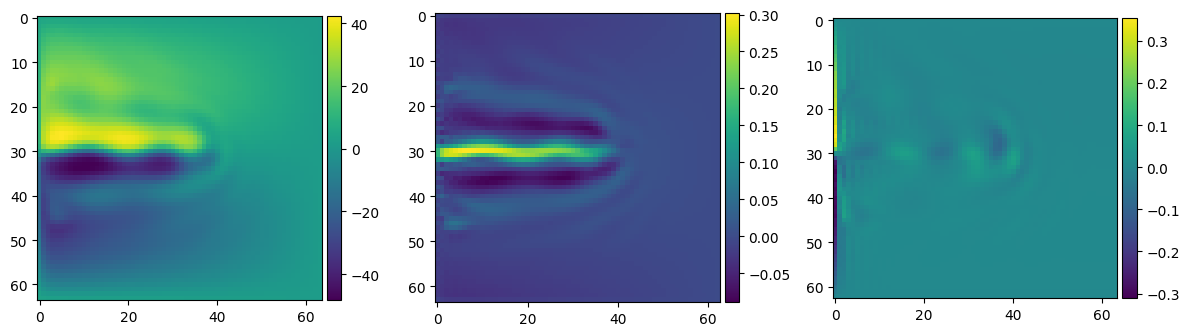

In [11]:
plot_state(data[:, 0])

In [12]:
def inference_model(state):
    if len(state.shape) == 1:
        state = state.reshape(-1, state_dimension)
        A_approx, singular_values, _vectors = model.to("cuda").construct_approx(
            torch.tensor(state, device="cuda")
        )
        singular_values = singular_values.cpu().detach().numpy().squeeze()
        sorted_idx = np.argsort(singular_values)[::-1]
        singular_values = singular_values[sorted_idx]
        _vectors = _vectors.squeeze().cpu().detach().numpy()[:, sorted_idx]
        vectors = np.linalg.qr(_vectors)[0]
        return A_approx, singular_values, vectors, _vectors

In [13]:
len(state.shape ) > 1

False

In [14]:
data = np.load('/data/data_data_assimilation/shallow_water/large/gn_data_0000.npy')
state = data[:, 0]
A_approx, singular_values, vectors, _vecs1 = inference_model(state)
data2 = np.load('/data/data_data_assimilation/shallow_water/large/gn_data_0500.npy')
state2 = data2[:, 0]
A_approx2, singular_values2, vectors2, _vecs2 = inference_model(state2)

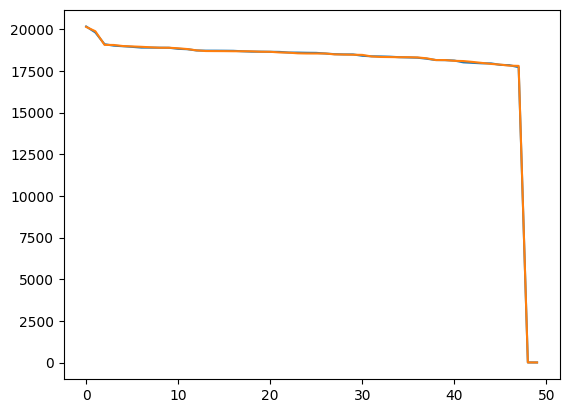

In [15]:
for i in range(10):
    data_i = np.load(f'/data/data_data_assimilation/shallow_water/large/gn_data_{i:04d}.npy')
    state_i = data_i[:, 0]
    A_approx2, singular_values2, vectors2, _vecs2 = inference_model(state_i)
plt.plot(singular_values)
plt.plot(singular_values2)

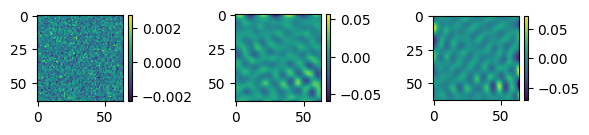

<Figure size 640x480 with 0 Axes>

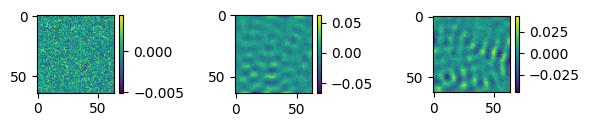

<Figure size 640x480 with 0 Axes>

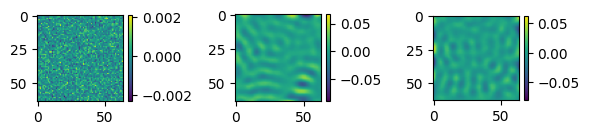

<Figure size 640x480 with 0 Axes>

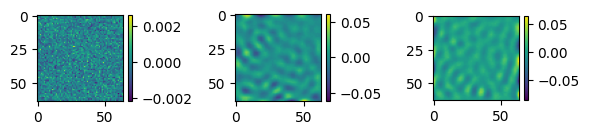

<Figure size 640x480 with 0 Axes>

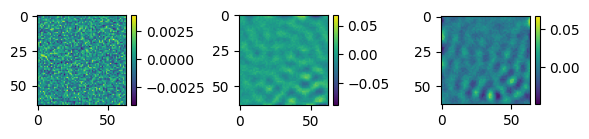

<Figure size 640x480 with 0 Axes>

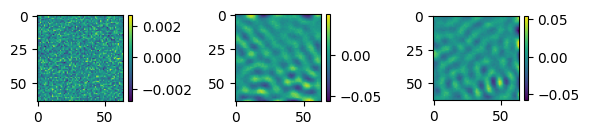

<Figure size 640x480 with 0 Axes>

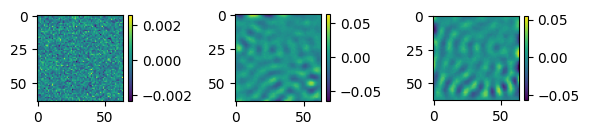

<Figure size 640x480 with 0 Axes>

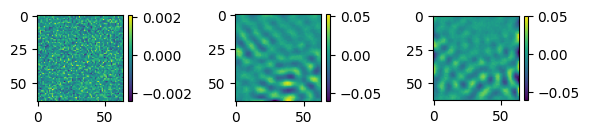

<Figure size 640x480 with 0 Axes>

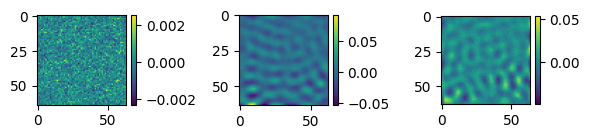

<Figure size 640x480 with 0 Axes>

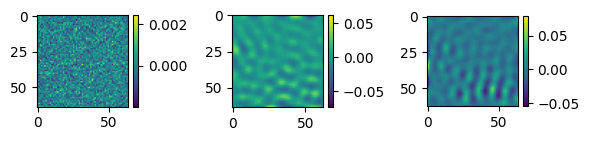

<Figure size 640x480 with 0 Axes>

In [16]:
for idx in range(10):
    plot_state(vectors[:, idx], figsize=(6, 4))
    plt.figure()

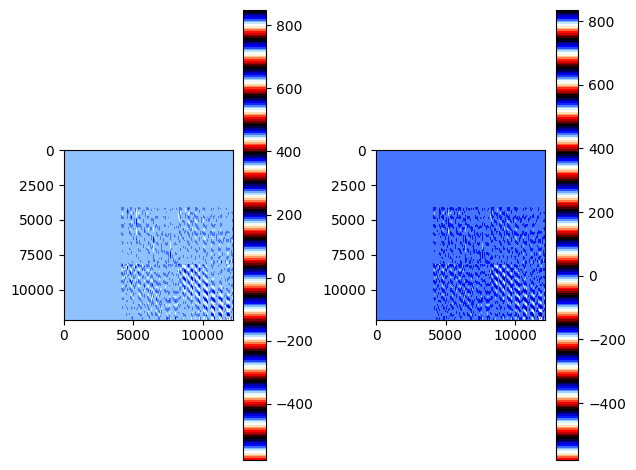

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(A_approx.cpu().detach().numpy().squeeze(), cmap='flag')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(A_approx2.cpu().detach().numpy().squeeze(), cmap='flag')
plt.colorbar()
plt.tight_layout()

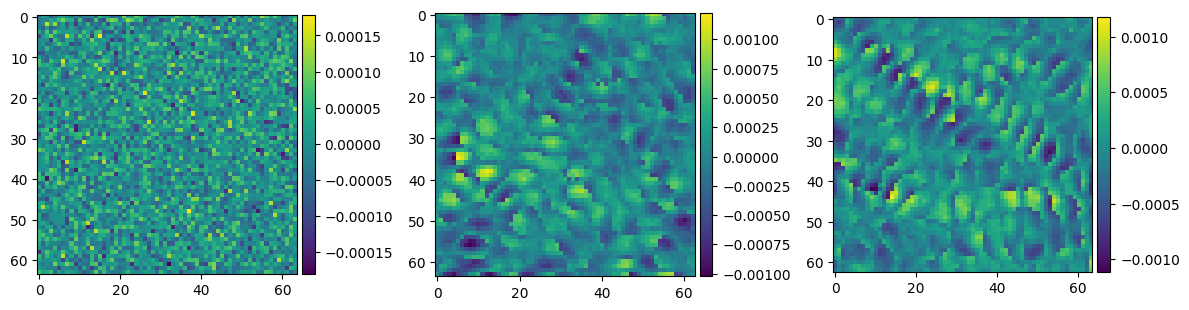

<Figure size 640x480 with 0 Axes>

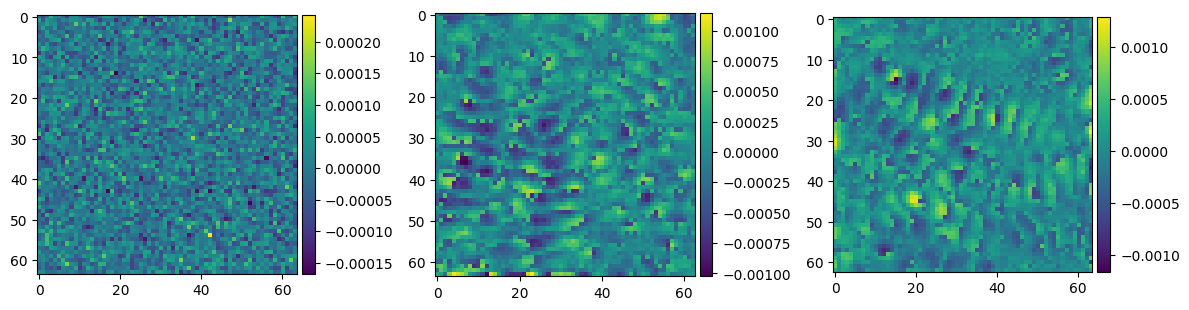

<Figure size 640x480 with 0 Axes>

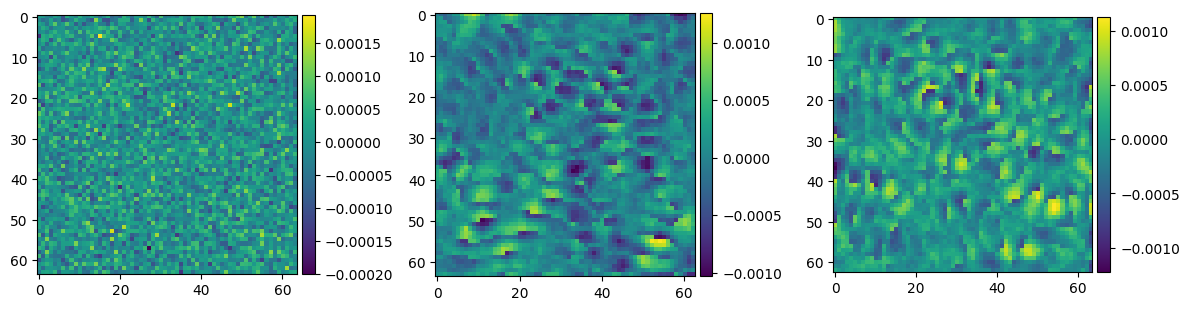

<Figure size 640x480 with 0 Axes>

In [21]:
for idx in range(3):
    plot_state(np.abs(vectors[:, idx])-np.abs(vectors2[:, idx]))
    plt.figure()

In [19]:
import torch
x = torch.randn(size=(3, 64, 64)).reshape(3, 64, 64)

In [20]:
x

tensor([[[-1.7120, -0.7465, -0.1726,  ...,  0.2115, -0.1475,  0.7751],
         [ 1.2678, -1.0673, -0.9217,  ..., -0.1374,  0.8269,  0.3007],
         [ 0.2555, -0.5120, -1.0333,  ...,  1.4512, -0.9176,  1.1965],
         ...,
         [ 0.0418, -0.1221,  0.0648,  ...,  0.9065, -1.8964, -0.0902],
         [-0.3095, -0.8546,  0.6856,  ..., -0.7669,  0.2246, -0.9549],
         [-0.5663, -0.5249, -0.4113,  ...,  0.9558, -1.1020, -2.2802]],

        [[-1.5944, -0.7132, -1.0905,  ...,  0.5885, -0.2553, -0.6362],
         [-2.0423,  1.4687,  0.5671,  ...,  0.6523, -0.6343, -0.9633],
         [-0.0456,  0.4016, -1.2148,  ...,  0.6512, -0.1643,  0.2704],
         ...,
         [-1.7409, -0.6442,  2.1605,  ...,  0.8739, -1.2085,  0.8747],
         [ 1.2066, -2.9242, -0.3705,  ...,  0.8906,  0.3539, -0.8285],
         [ 0.3132,  0.5221,  0.2132,  ..., -0.3494, -1.4178, -0.9014]],

        [[-0.3779, -0.3925,  1.3563,  ..., -0.2091, -1.0776, -0.0762],
         [ 0.4652,  0.5074, -0.3469,  ..., -0